In [64]:
import sys
sys.path.insert(0, "/mnt/arquivos_linux/wile_C/Predictive_Maintenance_free_dataset/")
import torch
from matplotlib.pyplot import figure
from datasets import DatasetSinteticUnsupervisedLSTM

figure(figsize=(8, 6), dpi=80)

limiter = 2000

# ABS_PATH = '/mnt/arquivos_linux/wile_C/Predictive_Maintenance_free_dataset'

test_dataset = DatasetSinteticUnsupervisedLSTM(dir_data='../Datasets/sintetic_dataset/26000_points/train_compressor_data.h5',
                                               context=400,
                                               stride=1)

test_loader = torch.utils.data.DataLoader(
                test_dataset, batch_size=1, shuffle=False
                )

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25600/25600 [00:00<00:00, 1437097.57it/s]

len dataset:25600


<Figure size 640x480 with 0 Axes>

In [65]:
def union_vector_predicted_dict(data_predict:dict):
    
    x_concat = data_predict[0]
    
    del data_predict[0]
    
    keys_predicted = list(data_predict.keys())
    
    for key in keys_predicted:
        x_concat = torch.concat((x_concat, data_predict[key]), dim=1)
        #x_concat = torch.concat((x_concat, data_predict[key]), dim=2)
        
        del data_predict[key]
    
    return x_concat

In [78]:
data_predict = torch.load(f"../models_h5/generate_evaluate/sintetic_generate_data_transformer_26000.pt")

In [79]:
data_predict[0].shape

torch.Size([1, 1, 1])

In [80]:
vet_predict = union_vector_predicted_dict(data_predict)

In [81]:
vet_predict[0,400:600,0].shape

torch.Size([200])

## Concat Vets

In [82]:
# x_true, _ = test_loader.dataset[0]

# get_n_elements = len(test_loader.dataset)

# for i in range(1, get_n_elements):
    
#     x_second, _ = test_loader.dataset[i]
    
#     x_true = torch.concat((x_true, x_second), dim=0)
    
x_true = test_dataset.data

x_true.shape, vet_predict.shape

((26000, 1), torch.Size([1, 26000, 1]))

### First channel

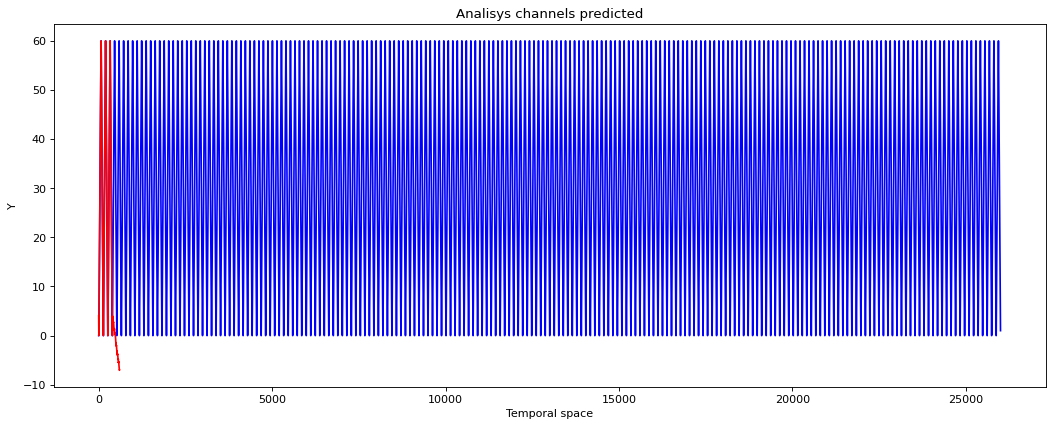

In [83]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

figure(figsize=(16, 6), dpi=80)
init_limiter = 0
limiter = init_limiter + 5400

#plt.plot(data_normal_train[:limiter,0])

#fig, axs = plt.subplots(1, 2, figsize=(15, 15))

feature_channel = 0
plt.xlabel('Temporal space')
plt.ylabel('Y')
plt.title("Analisys channels predicted")
# plt.plot(x_true[init_limiter:limiter, feature_channel], color='blue', label='sinal Real')
# plt.plot(vet_predict[0][init_limiter:limiter, feature_channel], color='r', label='sinal previsto')
plt.plot(x_true, color='blue', label='sinal Real')
plt.plot(vet_predict[0,:600,0], color='r', label='sinal previsto')


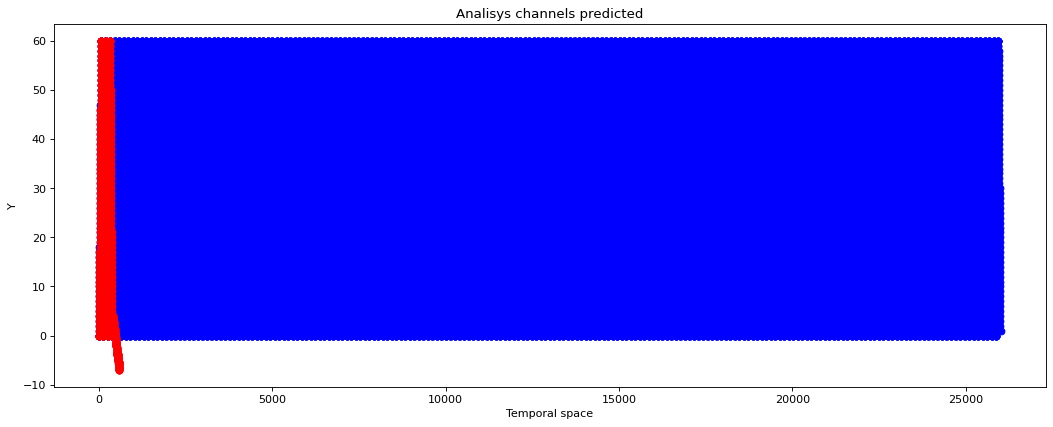

In [84]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

figure(figsize=(16, 6), dpi=80)
init_limiter = 400
limiter = init_limiter + 5400

#plt.plot(data_normal_train[:limiter,0])

#fig, axs = plt.subplots(1, 2, figsize=(15, 15))

feature_channel = 0
plt.xlabel('Temporal space')
plt.ylabel('Y')
plt.title("Analisys channels predicted")
# plt.plot(x_true[init_limiter:limiter, feature_channel], color='blue', label='sinal Real')
# plt.plot(vet_predict[0][init_limiter:limiter, feature_channel], color='r', label='sinal previsto')
plt.plot(x_true, "o", color='blue', label='sinal Real')
plt.plot(vet_predict[0, :600, 0], "o", color='r', label='sinal previsto')


In [85]:
from soft_dtw_cuda import SoftDTW

sdtw = SoftDTW(use_cuda=True, gamma=0.1)

def smape_loss(y_pred, target):
    # y_pred = y_pred.squeeze(2)
    loss = 2 * abs((y_pred - target)) / (abs(y_pred) + abs(target) + 1e-8)
    return loss.mean()*100



In [86]:
x_true.shape, vet_predict.shape

((26000, 1), torch.Size([1, 26000, 1]))

In [87]:
# def soft_dtw(y_pred, target):
#     #loss = sdtw(y_pred.unsqueeze(2), target.unsqueeze(2))
#     loss = sdtw(y_pred[np.newaxis, :, np.newaxis],
#                 target[np.newaxis, :, np.newaxis])
    
#     return loss.mean()
init_limiter = 400
slice_data = 26000
slice_data_true = x_true[init_limiter:slice_data, 0]
print(slice_data_true.shape)

slice_data_pred = vet_predict[0, init_limiter:slice_data, 0].numpy()
print(slice_data_pred.shape)

abs_data = abs(slice_data_true - slice_data_pred)
# Mean absolut error
print(f"Mean absolut error: {abs_data.mean()}")

sum_square = 0
for i, elem in enumerate(slice_data_true):
    sum_square += (slice_data_true[i] - slice_data_pred[i])**2

sum_square = sum_square/(i+1)
    
#Mean square error
print(f"Sum square error: {sum_square}")

#SMAPE
print(f"smape loss: {smape_loss(slice_data_true, slice_data_pred)}")

#soft DTW

# soft_dtw(slice_data_true, slice_data_pred)

(25600,)
(25600,)
Mean absolut error: 37.13192013638356
Sum square error: 2044.0042805337607
smape loss: 134.385297492959


In [88]:
abs_data = abs(slice_data_true - slice_data_pred)
#abs_data

In [77]:
import numpy as np
# In terms of interpreting the SMAPE, a value of zero indicates perfect accuracy,
# while larger values indicate greater forecasting error. A SMAPE of 100%
# indicates that the model's forecasts are completely off-base,
# predicting values that are twice the actual values on average.


print(f"differents form: {smape_loss(np.arange(1,100), np.arange(100,1, -1))}")
print(f"same form: {smape_loss(np.arange(1,100), np.arange(1, 100))}")

differents form: 98.02980297059212
same form: 0.0


In [48]:
def transform_for_days(x):
    x = (((x*10)/60)/60)/24
    return x

def transform_for_hour(x):
    x = (x*24)
    return x

def transform_for_min(x):
    x = (x*60)
    return x

print(transform_for_days(9100))
print(transform_for_hour(0.05))
print(transform_for_hour(1))

1.0532407407407407
1.2000000000000002
24


In [21]:
days(7)/10

60480.0